### MNIST 모델링으로 Fashion_Mnist 데이터 입력하여 분류하면 제대로 못함
> 어떻게 잘못 분류됨을 파악할수 있을까?

### MNIST 모델링

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(x_train,y_train) ,(x_test,y_test) = mnist.load_data()

In [4]:
x_train = x_train[:,:,:,tf.newaxis]
x_test = x_test[:,:,:, tf.newaxis]

In [5]:
x_train.shape, y_train.shape, type(x_train), type(y_train)

((60000, 28, 28, 1), (60000,), numpy.ndarray, numpy.ndarray)

In [6]:
def processing(img, label):
  img = img/255.
  return img, label

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train.astype(float), y_train.astype(float)))
train_ds = train_ds.map(processing).shuffle(1000).batch(128).prefetch(1)

In [8]:
train_ds

<PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float64, tf.float64)>

In [9]:
X = tf.keras.layers.Input(shape=(28,28,1), name='INPUT_LAYER')
H = tf.keras.layers.Conv2D(64,3,strides=1, padding='same', activation='relu')(X)
H = tf.keras.layers.MaxPooling2D((2,2))(H)
H = tf.keras.layers.Conv2D(64,3,strides=1, padding='same', activation='relu')(H)
H = tf.keras.layers.MaxPooling2D((2,2))(H)
H = tf.keras.layers.Flatten()(H)
H = tf.keras.layers.Dense(64, activation='relu')(H)
H = tf.keras.layers.Dense(10, activation=None, name='OUTPUT_LAYER_SCORE')(H)
Y = tf.keras.layers.Softmax(name='OUTPUT_LAYER_SOFTMAX')(H)

model = tf.keras.Model(X, Y)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT_LAYER (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                200768

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [11]:
step = round(x_train.shape[0]/128)

In [12]:
model.fit(x_train, y_train, epochs=5, steps_per_epoch=step, validation_split=0.2)

Epoch 1/5
469/469 [==============================] - 5s 7ms/step - loss: 2.0539 - accuracy: 0.8092 - val_loss: 0.0861 - val_accuracy: 0.9742
Epoch 2/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0735 - accuracy: 0.9767 - val_loss: 0.0743 - val_accuracy: 0.9787
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0492 - accuracy: 0.9843 - val_loss: 0.0745 - val_accuracy: 0.9796
Epoch 4/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0386 - accuracy: 0.9872 - val_loss: 0.0677 - val_accuracy: 0.9827
Epoch 5/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0276 - accuracy: 0.9911 - val_loss: 0.0672 - val_accuracy: 0.9836


### MNIST 모델에 fashion_mnist 데이터 입력

In [13]:
[fashine_train_x, fashine_train_y], [fashine_test_x, fashine_test_y] = tf.keras.datasets.fashion_mnist.load_data()

In [14]:
tmp_data = fashine_train_x[1]

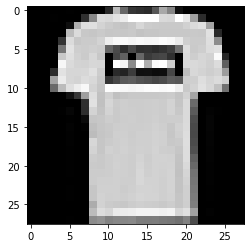

In [15]:
import matplotlib.pyplot as plt
plt.imshow(tmp_data, cmap='gray')

In [16]:
# 티셧츠 그림을 주었는데 MNIST 모델에서 8으로 분류
import numpy as np

tmp_data = tf.reshape(tmp_data, [1, 28, 28, 1])
pred = model.predict(tmp_data)
print(pred)
print(np.argmax(pred))

[[1.5730731e-04 8.7336797e-05 2.7595672e-03 5.5071497e-03 3.5989069e-05
  8.2680846e-05 5.1605975e-04 7.1260365e-06 9.9084657e-01 2.1010241e-07]]
8


### MNIST 모델의 layer 확인하고 layer를 수정해서 새로운 모델 만들어 output layer의 Score(점수) 확인해 보자

In [19]:
model.layers

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT_LAYER (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                200768

In [21]:
print(model.get_layer('INPUT_LAYER').input)
print(model.get_layer('INPUT_LAYER').output)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='INPUT_LAYER'), name='INPUT_LAYER', description="created by layer 'INPUT_LAYER'")
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='INPUT_LAYER'), name='INPUT_LAYER', description="created by layer 'INPUT_LAYER'")


In [23]:
test_model = tf.keras.Model(
    inputs=model.get_layer('INPUT_LAYER').input,
    outputs=[model.get_layer('OUTPUT_LAYER_SCORE').output, model.get_layer('OUTPUT_LAYER_SOFTMAX').output]
)

In [24]:
test_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT_LAYER (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2007

In [25]:
test_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics='accuracy')

In [26]:
test_model.fit(x_train, y_train, epochs=5, steps_per_epoch=step, validation_split=0.2)

Epoch 1/5
469/469 [==============================] - 4s 7ms/step - loss: 1.0910 - OUTPUT_LAYER_SCORE_loss: 0.9855 - OUTPUT_LAYER_SOFTMAX_loss: 0.1055 - OUTPUT_LAYER_SCORE_accuracy: 0.9716 - OUTPUT_LAYER_SOFTMAX_accuracy: 0.9716 - val_loss: 0.8641 - val_OUTPUT_LAYER_SCORE_loss: 0.7548 - val_OUTPUT_LAYER_SOFTMAX_loss: 0.1093 - val_OUTPUT_LAYER_SCORE_accuracy: 0.9791 - val_OUTPUT_LAYER_SOFTMAX_accuracy: 0.9791
Epoch 2/5
469/469 [==============================] - 3s 7ms/step - loss: 0.8686 - OUTPUT_LAYER_SCORE_loss: 0.8198 - OUTPUT_LAYER_SOFTMAX_loss: 0.0488 - OUTPUT_LAYER_SCORE_accuracy: 0.9860 - OUTPUT_LAYER_SOFTMAX_accuracy: 0.9860 - val_loss: 0.6830 - val_OUTPUT_LAYER_SCORE_loss: 0.6173 - val_OUTPUT_LAYER_SOFTMAX_loss: 0.0657 - val_OUTPUT_LAYER_SCORE_accuracy: 0.9852 - val_OUTPUT_LAYER_SOFTMAX_accuracy: 0.9852
Epoch 3/5
469/469 [==============================] - 3s 7ms/step - loss: 0.6603 - OUTPUT_LAYER_SCORE_loss: 0.6320 - OUTPUT_LAYER_SOFTMAX_loss: 0.0283 - OUTPUT_LAYER_SCORE_accurac

In [30]:
# pred_score 값을 보면 + 값이 하나도 없다. 즉, 분류시 +값이 있어야 제대로 분류가 되는데 없으니 제대로 분류가 안된다고 알려줌
pred_score, pred_softmax = test_model.predict(tmp_data)
print(pred_score)
print(pred_softmax)
print(np.argmax(pred_softmax))

[[-18.283007 -17.698519 -17.516762 -15.967876 -12.966067 -15.921283
  -18.223768 -13.502399  -6.45911  -14.91437 ]]
[[7.30707507e-06 1.31094175e-05 1.57224240e-05 7.39932002e-05
  1.48888363e-03 7.75223234e-05 7.75301214e-06 8.70832591e-04
  9.97232735e-01 2.12189581e-04]]
8


### MNIST 데이터 하나를 가지고 분류해 보고 Score 값도 확인해 보자

In [32]:
x_train[0].shape

(28, 28, 1)

In [33]:
# pred_score 값중에서 + 값이 확연히 보임.
pred_score, pred_softmax = test_model.predict(x_train[0].reshape(1,28,28,1))
print(pred_score)
print(pred_softmax)
print(np.argmax(pred_softmax))

[[-29.96821   -26.141878  -30.979338    3.8686793 -24.527292   13.271329
  -22.347185  -15.189188  -14.929717  -15.664749 ]]
[[1.6644492e-19 7.6388045e-18 6.0554080e-20 8.2498344e-05 3.8391153e-17
  9.9991751e-01 3.3965624e-16 4.3623278e-13 5.6546472e-13 2.7113500e-13]]
5


In [ ]:
.